In [121]:
import zipfile
import cv2
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt


In [122]:
# 计算成对的欧式距离
def pairwise_distances(Data):
    n = len(Data)  # 获取数据集中样本点的数量
    dist_matrix = np.zeros((n, n))  # 初始化一个全零矩阵，用于存储样本点之间的欧式距离
    for i in range(n):  # 遍历数据集中的每个样本点
        for j in range(i+1, n):  # 遍历数据集中的其他样本点，避免重复计算距离
            # 计算数据矩阵中样本点 i 和 j 之间的欧式距离
            dist_matrix[i][j] = dist_matrix[j][i] = np.linalg.norm(Data[i] - Data[j])
            # 将距离赋值给对称位置，因为距离矩阵是对称的
    return dist_matrix  # 返回样本点之间的欧式距离矩阵

# 计算数据集中每个样本点的k个最近邻
def k_nearest_neighbors(Data, n_neighbors):
    dist_matrix = pairwise_distances(Data)  # 获取样本点之间的欧式距离矩阵
    return np.argsort(dist_matrix, axis=1)[:, 1:n_neighbors + 1]  # 返回每个样本点的k个最近邻的索引

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, n_neighbors, t):
    neighborhood_matrix = k_nearest_neighbors(Data, n_neighbors)
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    dist_matrix = pairwise_distances(Data)
    for i in range(n):  # 对于数据集中的每个样本点 i
        for j in neighborhood_matrix[i]:  # 对于样本点 i 的邻居点 j
            # 使用热核方法计算权重，这里的欧式距离已经归一化
            Weight_matrix[i][int(j)] = np.exp(-dist_matrix[i][int(j)] ** 2 / (4 * t)) * 1 / ((4 * np.pi * t) ** (1 / 2))
            # 邻接矩阵为对称矩阵，因此需要同时更新Weight_matrix的[i][j]和[j][i]位置
            Weight_matrix[int(j)][i] = Weight_matrix[i][int(j)]  
    return Weight_matrix


# 进行特征映射
def eigen_mapping(Laplacian_matrix, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    return selected_eigenvectors

# LPP 算法
def LPP(Data, n_components, n_neighbors, t):
    # Step 1: 构建基于权重矩阵
    Weight_matrix = construct_weight_matrix(Data, n_neighbors, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, n_components)
    return selected_eigenvectors

显示示例人脸图像


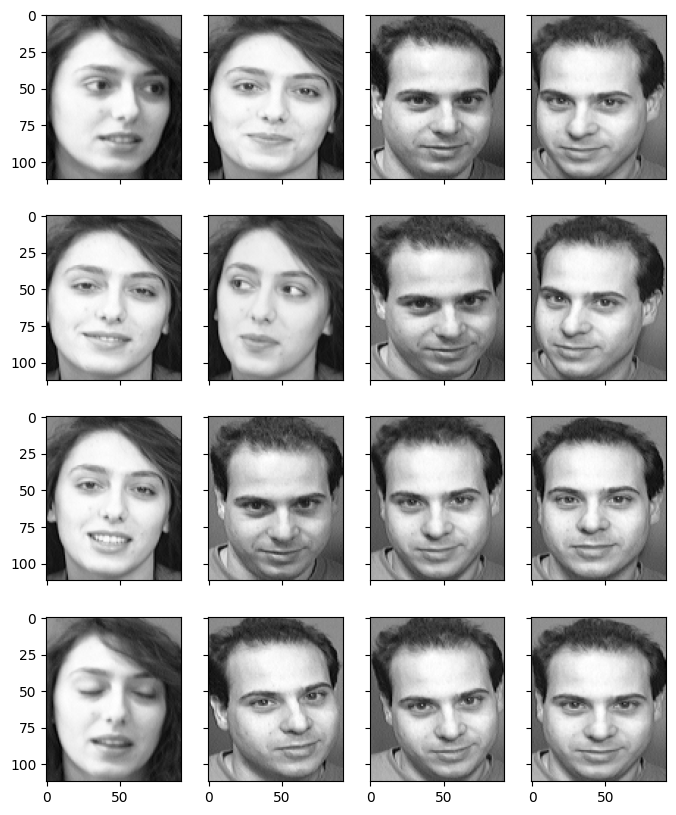

人脸图像形状: (112, 92)
类别数量: 10
图像数量: 100


In [123]:
# 从zip文件中读取人脸图像
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # 不是人脸图像
        with facezip.open(filename) as image:
            # 如果我们解压了zip文件，可以使用cv2.imread(filename)代替
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)


# 使用matplotlib显示示例人脸图像
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
faceimages = list(faces.values())[-16:] # 取最后16张图像
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("显示示例人脸图像")
plt.show()

# 打印一些细节
faceshape = list(faces.values())[0].shape
print("人脸图像形状:", faceshape)

# 从文件名中提取类别
classes = set(filename.split("/")[0] for filename in faces.keys())

print("类别数量:", len(classes))
print("图像数量:", len(faces))

In [124]:
from lpproj import LocalityPreservingProjection

权重矩阵形状: (25, 86)
显示特征脸


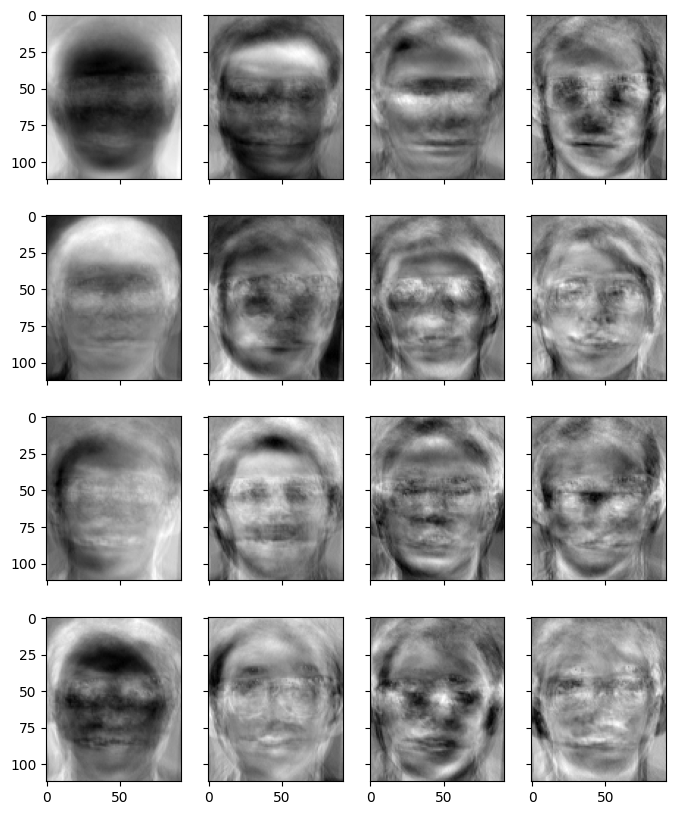

34

In [125]:
# 加载人脸数据集
facematrix = []
facelabel = []
for key, val in faces.items():
    if key.startswith("s10/"):
        continue # 这是我们的测试集
    if key == "s3/10.pgm":
        continue # 这是我们的测试集
    if key == "s8/2.pgm":
        continue # 这是我们的测试集
    if key == "s7/6.pgm":
        continue # 这是我们的测试集
    if key == "s8/4.pgm":
        continue # 这是我们的测试集
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

# 创建一个NxM矩阵，其中N为图像数量，M为每个图像的像素数
facematrix = np.array(facematrix)

# 转置facematrix以匹配矩阵乘法的预期形状
facematrix = facematrix.T

# 应用LPP并选择前K个主成分作为特征脸
n_components = 25
n_neighbors = 30
t = 2400

# eigenfaces = LPP(facematrix, n_components, n_neighbors, t)
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components=n_components)
lpp.fit(facematrix)
eigenfaces = lpp.transform(facematrix)

# 生成权重矩阵，其中K为特征脸数量，N为样本数量
weights = eigenfaces.T @ facematrix
print("权重矩阵形状:", weights.shape)

# 显示前16个特征脸
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faces["s1/1.pgm"].shape), cmap="gray")
print("显示特征脸")
plt.show()
34

In [126]:
def test_image(image_path, eigenfaces, mean_face, facelabel, weights):
    # 读取测试图像
    test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    test_image_flatten = test_image.flatten()

    # 加载测试图像数据
    test_data = test_image_flatten.reshape(1, -1)

    # 计算测试图像的权重向量
    query_weight = eigenfaces.T @ (test_data.T - mean_face)

    # 计算测试图像与数据集中每个人脸的欧氏距离
    euclidean_distances = np.linalg.norm(weights - query_weight, axis=0)

    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    best_match_label = facelabel[best_match_index]

    return best_match_label, euclidean_distances[best_match_index]


最佳匹配的人脸标签: s7
与测试图像的欧氏距离: 2007.9638052982662


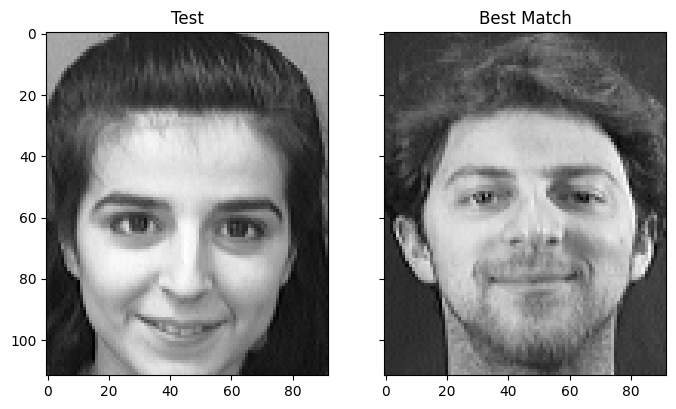

In [127]:
# 测试图像路径
image_path = "attface/s10/2.pgm"

# 测试图像并获取结果
mean_face = np.mean(facematrix, axis=0)
best_match_label, euclidean_distance = test_image(image_path, eigenfaces, mean_face, facelabel, weights)

# 打印测试结果
print("最佳匹配的人脸标签:", best_match_label)
print("与测试图像的欧氏距离:", euclidean_distance)
# 可视化
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
axes[0].imshow(test_image, cmap="gray")
axes[0].set_title("Test")
best_match_image = faces[best_match_label + "/1.pgm"]
axes[1].imshow(best_match_image, cmap="gray")
axes[1].set_title("Best Match")
plt.show()